# Import Libraries


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt



---

#Load and Prepare CIFAR-10 Data
Here, I load the CIFAR-10 dataset. Convolutional layers work directly with the 2D structure of the images. I normalized the pixel values to be between 0 and 1 by dividing by 255.
The shape of our data will be `(num_samples, 32, 32, 3)`.

In [2]:
(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples




---
# Define the Encoder Architecture
The encoder's job is to compress the input image into a smaller, dense representation. We use a stack of Conv2D layers to learn features and MaxPooling2D layers to downsample the image dimensions. The image starts at 32x32x3 and is compressed down to 4x4x128.


In [3]:
input_img = Input(shape=(32, 32, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)



---
# Define the Decoder Architecture
The decoder reconstructs the image from the compressed representation. It's essentially a mirror image of the encoder. We use UpSampling2D to increase the dimensions and Conv2D layers to refine the image details. The final layer uses a sigmoid activation to ensure the output pixel values are in the range [0, 1].


In [4]:
x = Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(encoded)
x = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)



---
# Create and Compile the Autoencoder Model
Now we define the full autoencoder model by specifying its input and output. We compile the model using the adam optimizer and binary_crossentropy as the loss function, which works well for comparing pixel values.


In [5]:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)



---

# Train the Model
We train the model using the training data as both the input and the target. This is the core idea of an autoencoder: it learns to reconstruct its own input. We also use the test data for validation to monitor performance.

In [6]:
history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[early_stopper, reduce_lr]
               )

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.0287 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0093 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0075 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0064 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0059 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0056 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0052 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0050 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 9/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0048 - val_loss: 0.0047 - learning_r



---
# Plot Training History
This block visualizes the model's performance during training.


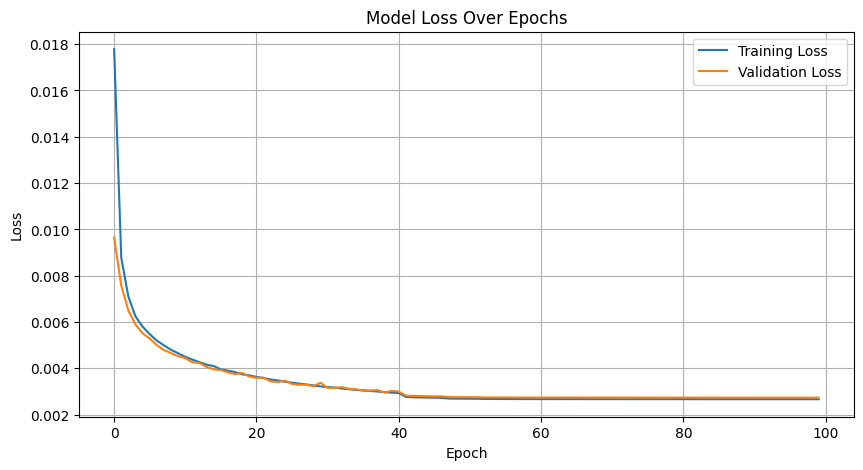

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()



---
# Visualize the Results
Finally, we use our trained autoencoder to reconstruct the images from the test set. We then plot the original images and their reconstructed versions side-by-side to visually inspect the quality of the reconstruction.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


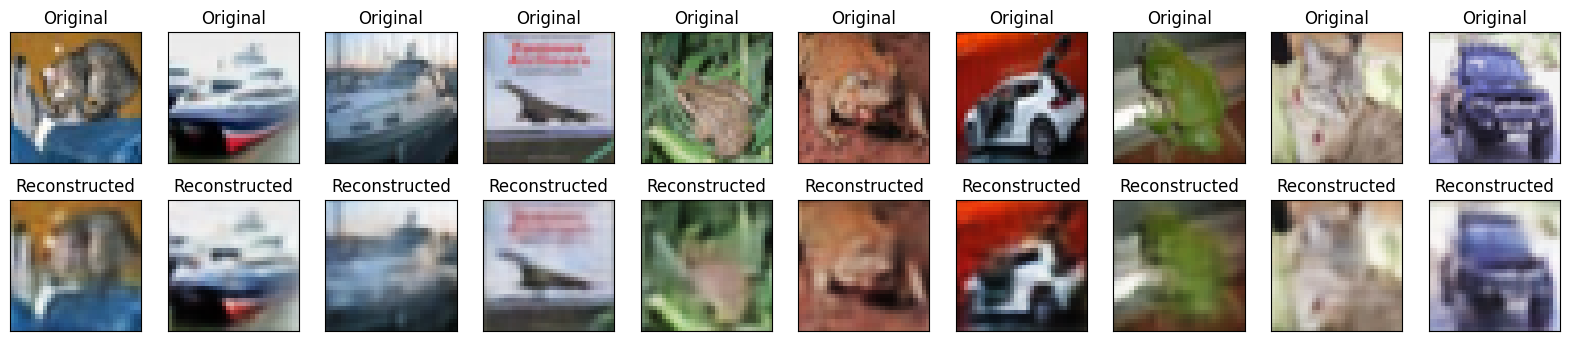

In [12]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()